# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_file = '../data/processed/hourly_train.csv'
test_file = '../data/processed/hourly_test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Ensure 'date' is in datetime format and set as index
train_data['date'] = pd.to_datetime(train_data['date'])  
train_data.set_index('date', inplace=True)
train_data = train_data.asfreq('h')

test_data['date'] = pd.to_datetime(test_data['date'])  
test_data.set_index('date', inplace=True)
test_data = test_data.asfreq('h')

print(f'Train size: {train_data.shape}, Test size: {test_data.shape}')

Train size: (3144, 31), Test size: (120, 31)


## Sarimax Model without Regressors

C:\Users\yafa917\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


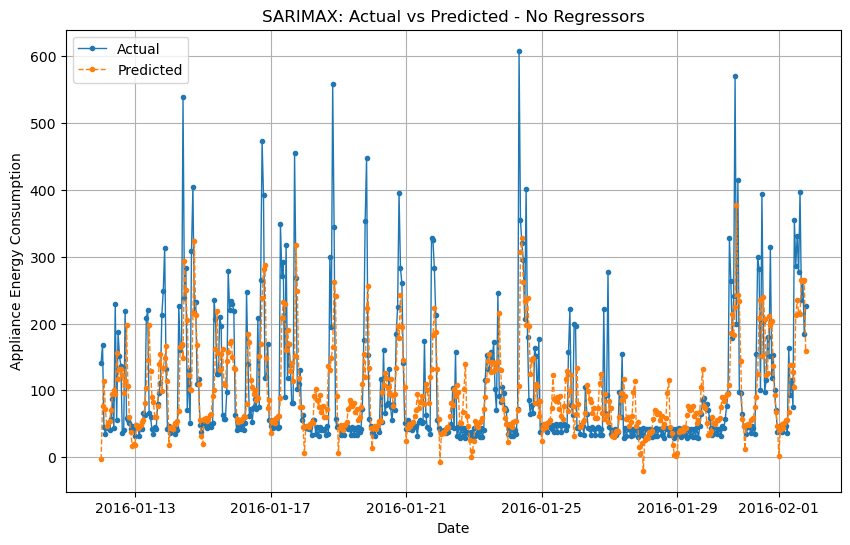

,coef,std err,z,P>|z|,[0.025,0.975]
is_weekend,9.0306,4.612,1.958,0.050,-0.009,18.070
absent_day,-29.7142,10.629,-2.796,0.005,-50.547,-8.882
day_of_week_1,-2.9076,7.925,-0.367,0.714,-18.441,12.626
day_of_week_2,3.0987,9.606,0.323,0.747,-15.729,21.927
day_of_week_3,-2.0136,8.884,-0.227,0.821,-19.425,15.398
day_of_week_4,15.2384,8.301,1.836,0.066,-1.031,31.508
day_of_week_5,6.2654,4.950,1.266,0.206,-3.437,15.968
day_of_week_6,2.7652,5.341,0.518,0.605,-7.702,13.233
hour_1,25.6710,26.068,0.985,0.325,-25.420,76.762
hour_2,31.8434,37.468,0.850,0.395,-41.592,105.279


In [3]:
# SARIMA Model Parameters without regresssors
categorical_vars = train_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
exog_vars = pd.get_dummies(categorical_vars, columns=['day_of_week', 'hour'], drop_first=True)
exog_vars = exog_vars.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

model1 = SARIMAX(train_data['Appliances'], 
                exog = exog_vars,
                order=(2, 0, 0),              # AR(2), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the SARIMA Model
sarima_result1 = model1.fit(disp=False)
# align indices
fitted_values = sarima_result1.fittedvalues
fitted_values.index = train_data.index[fitted_values.shape[0] * -1:] 

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_data['Appliances'].iloc[:500], label='Actual', marker='.', linewidth=1)
plt.plot(fitted_values.iloc[:500], label='Predicted', marker='.', linewidth=1, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Actual vs Predicted - No Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Model Summary
model_summary1 = sarima_result1.summary()
model_summary1.tables[1]  

### Forecast using Sarimax Model

In [4]:
# Prepare prediction dataset
test_categoricals = test_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
test_exog = pd.get_dummies(test_categoricals, columns=['day_of_week', 'hour'], drop_first=True)
test_exog = test_exog.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
test_exog = test_exog.reindex(columns=exog_vars.columns, fill_value=0)

# Verify the structure
print(test_exog.columns)
print(test_exog.head())


Index(['is_weekend', 'absent_day', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')
                     is_weekend  absent_day  day_of_week_1  day_of_week_2  \
date                                                                        
2016-05-22 00:00:00           1           0              0              0   
2016-05-22 01:00:00           1           0              0              0   
2016-05-22 02:00:00           1           0              0              0   
2016-05-22 03:00:00           1           0              0              0   
2016-05-22 04:00:00           1           0              0              0   

                     

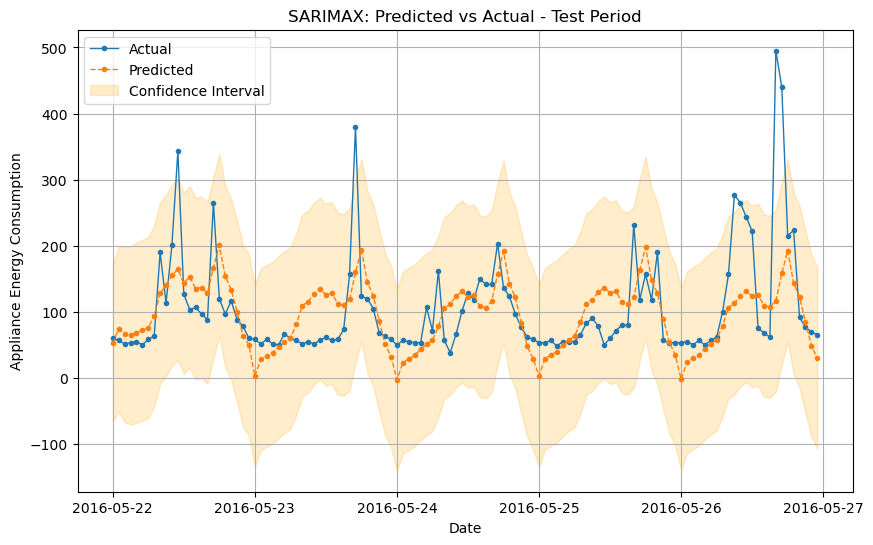

In [5]:
# Generate predictions for the test period
forecast_result1 = sarima_result1.get_forecast(steps=len(test_data), exog=test_exog)

# Extract predicted values and confidence intervals
forecasted_values1 = forecast_result1.predicted_mean
forecast_conf_int1 = forecast_result1.conf_int()

# Align indices with test data
forecasted_values1.index = test_data.index
forecast_conf_int1.index = test_data.index

# Plot Actual vs Predicted for the test period
plt.figure(figsize=(10, 6))
plt.plot(test_data['Appliances'], label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(forecasted_values1, label='Predicted', marker='.', linestyle='--', linewidth=1)
plt.fill_between(
    forecast_conf_int1.index,
    forecast_conf_int1.iloc[:, 0],
    forecast_conf_int1.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Evaluate Forecast Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast_horizon = 120

mape = (abs((test_data['Appliances'].iloc[:forecast_horizon] - forecasted_values1) /
            test_data['Appliances'].iloc[:forecast_horizon]).mean()) * 100

r2 = r2_score(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values1)

error_metrics_df = pd.DataFrame(columns=['Model', 'MAPE', 'R2'])

# Update the error metrics DataFrame
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'SARIMAX without Regressors',
    'MAPE': mape,
    'R2': r2
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)


                        Model       MAPE        R2
0  SARIMAX without Regressors  44.929899  0.257067


C:\Users\yafa917\AppData\Local\Temp\ipykernel_42704\46018914.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{


## Sarimax Model with External Regressors

C:\Users\yafa917\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


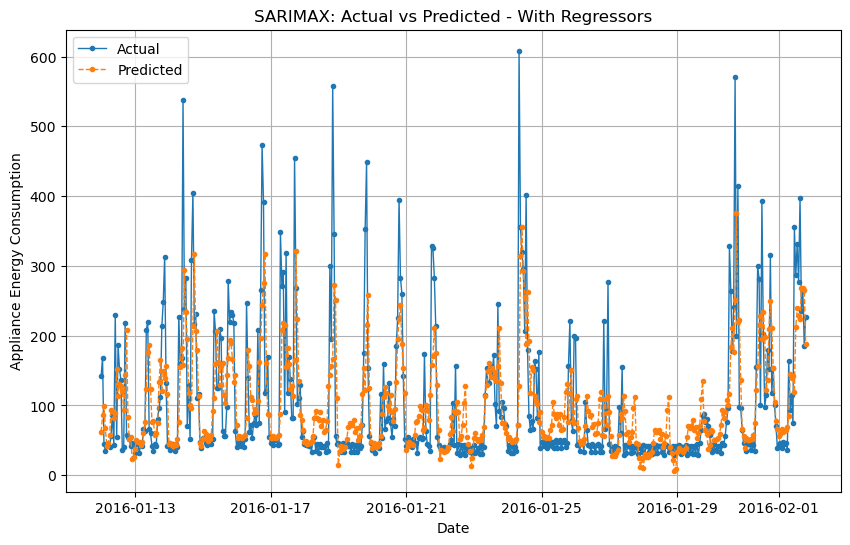

,coef,std err,z,P>|z|,[0.025,0.975]
lights,1.7972,0.173,10.412,0.000,1.459,2.135
T_out,0.6707,0.532,1.261,0.207,-0.372,1.714
RH_out,0.4824,0.135,3.584,0.000,0.219,0.746
is_weekend,1.0668,4.832,0.221,0.825,-8.403,10.537
absent_day,-32.1648,11.802,-2.725,0.006,-55.296,-9.034
day_of_week_1,-15.6422,8.621,-1.814,0.070,-32.539,1.255
day_of_week_2,-9.4934,9.691,-0.980,0.327,-28.488,9.501
day_of_week_3,-14.9650,8.880,-1.685,0.092,-32.370,2.440
day_of_week_4,5.8391,8.028,0.727,0.467,-9.895,21.573
day_of_week_5,2.0208,4.842,0.417,0.676,-7.469,11.510


In [7]:
# Regressors
categorical_vars = train_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
categorical_vars = pd.get_dummies(categorical_vars, columns=['day_of_week', 'hour'], drop_first=True)
exog_vars = pd.concat([train_data[['lights', 'T_out', 'RH_out']], categorical_vars], axis=1)
exog_vars = exog_vars.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# SARIMA Model Parameters without regresssors
model2 = SARIMAX(train_data['Appliances'], 
                exog=exog_vars,
                order=(2, 0, 0),              # AR(2), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the SARIMA Model
sarima_result2 = model2.fit(disp=False)
# align indices
fitted_values = sarima_result2.fittedvalues
fitted_values.index = train_data.index[fitted_values.shape[0] * -1:] 

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_data['Appliances'].iloc[:500], label='Actual', marker='.', linewidth=1)
plt.plot(fitted_values.iloc[:500], label='Predicted', marker='.', linewidth=1, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Actual vs Predicted - With Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Model Summary
model_summary2 = sarima_result2.summary()
model_summary2.tables[1]  

### Forecast using Sarimax Model with Forecasted Regressors

#### Forecast Regressors

In [8]:
# Define forecast horizon and frequency
forecast_horizon = 120
forecast_start_time = train_data.index[-1]  # Last timestamp in training data
forecast_dates = pd.date_range(
    start=forecast_start_time,
    periods=forecast_horizon + 1,  # Include the starting timestamp
    freq='h'  # Assuming hourly frequency
)[1:]  # Exclude the starting timestamp

# Forecast regressors
lights_model = SARIMAX(train_data['lights'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 24))
lights_result = lights_model.fit(disp=False)
lights_forecast = pd.Series(lights_result.forecast(steps=forecast_horizon), index=forecast_dates)

temp_model = SARIMAX(train_data['T_out'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 24))
temp_result = temp_model.fit(disp=False)
temp_forecast = pd.Series(temp_result.forecast(steps=forecast_horizon), index=forecast_dates)

humid_model = SARIMAX(train_data['RH_out'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 24))
humid_result = humid_model.fit(disp=False)
humid_forecast = pd.Series(humid_result.forecast(steps=forecast_horizon), index=forecast_dates)

# Combine into a DataFrame with the correct datetime index
forecasted_regressors = pd.DataFrame({
    'lights': lights_forecast,
    'T_out': temp_forecast,
    'RH_out': humid_forecast
})

forecasted_regressors.head(5)


,lights,T_out,RH_out
2016-05-22 00:00:00,1.119798e-17,18.677485,77.264084
2016-05-22 01:00:00,8.506518e-18,18.622777,76.962495
2016-05-22 02:00:00,6.461957e-18,18.510935,76.750177
2016-05-22 03:00:00,4.908811e-18,18.225232,77.071398
2016-05-22 04:00:00,3.728967e-18,17.765653,77.570741


In [9]:
forecasted_regressors['day_of_week'] = forecast_dates.dayofweek  # Monday=0, Sunday=6
forecasted_regressors['hour'] = forecast_dates.hour              # Hour of the day (0-23)
forecasted_regressors['is_weekend'] = (forecasted_regressors['day_of_week'] >= 5).astype(int)  # Weekend flag
forecasted_regressors['absent_day'] = 0 

# Convert day_of_week and hour to dummy variables for regression
forecasted_regressors = pd.get_dummies(forecasted_regressors, columns=['day_of_week', 'hour'], drop_first=True)
forecasted_regressors = forecasted_regressors.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Ensure all dummy variables are included in forecasted_regressors
for col in exog_vars.columns:
    if col not in forecasted_regressors.columns:
        forecasted_regressors[col] = 0  

# Align the column order with the training data
forecasted_regressors = forecasted_regressors[exog_vars.columns]
forecasted_regressors.shape


(120, 34)

#### Forecast using Sarimax Model with Regressors

In [10]:
# Generate predictions for the next 100 periods using the SARIMAX model
forecast_result2 = sarima_result2.get_forecast(steps=forecast_horizon, exog=forecasted_regressors)

# Extract the predicted values and confidence intervals
forecasted_values2 = forecast_result2.predicted_mean
forecast_conf_int2 = forecast_result2.conf_int()

# Align indices with the forecast period
forecasted_values2.index = test_data.index[:forecast_horizon]
forecast_conf_int2.index = test_data.index[:forecast_horizon]


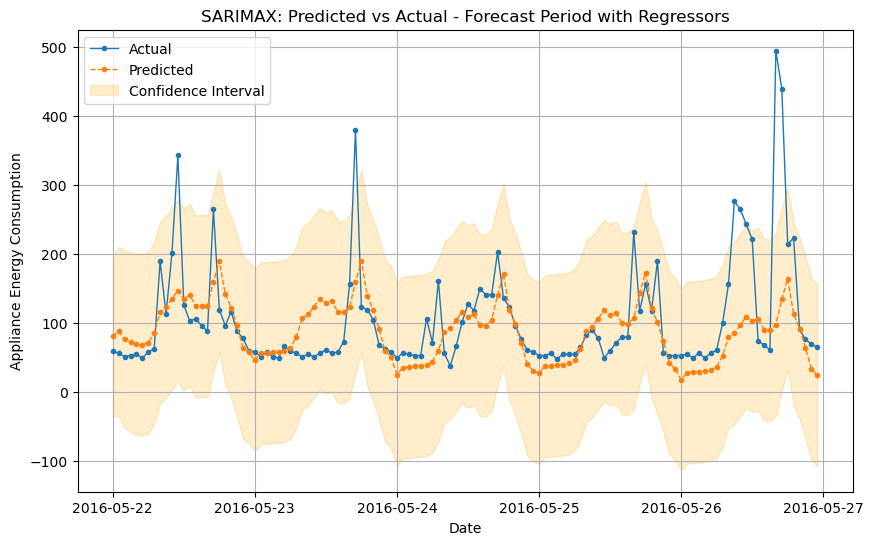

MAE: 43.35, MSE: 5141.34, RMSE: 71.70


In [11]:
# Plot Actual vs Predicted for the forecast period
plt.figure(figsize=(10, 6))
plt.plot(test_data['Appliances'].iloc[:forecast_horizon], label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(forecasted_values2, label='Predicted', marker='.', linestyle='--', linewidth=1)
plt.fill_between(
    forecast_conf_int2.index,
    forecast_conf_int2.iloc[:, 0],
    forecast_conf_int2.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Predicted vs Actual - Forecast Period with Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Forecast Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)
mse = mean_squared_error(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

In [12]:
# Evaluate Forecast Accuracy for the second SARIMAX model with regressors
mape2 = (abs((test_data['Appliances'].iloc[:forecast_horizon] - forecasted_values2) /
             test_data['Appliances'].iloc[:forecast_horizon]).mean()) * 100

r2_2 = r2_score(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)

# Update the error metrics DataFrame
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'SARIMAX with Regressors',
    'MAPE': mape2,
    'R2': r2_2
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)


                        Model       MAPE        R2
0  SARIMAX without Regressors  44.929899  0.257067
1     SARIMAX with Regressors  39.863817  0.188234


## Random Forest Model

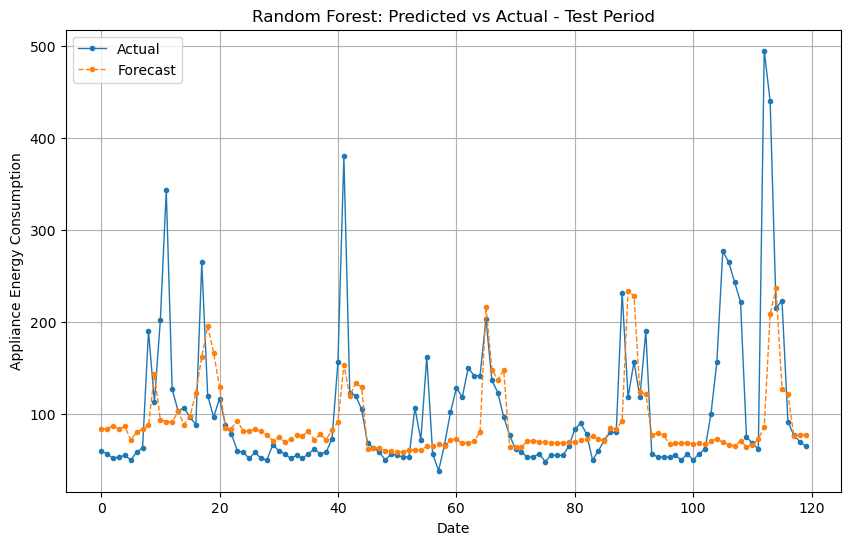

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare features and target
X_train = exog_vars
y_train =  train_data['Appliances'] 

X_test = forecasted_regressors
y_test = test_data['Appliances'] 

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=35)
rf_model.fit(X_train, y_train)  # Fit the model

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_rf, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Random Forest: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Error Metrics
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100
r2_rf = r2_score(y_test, y_pred_rf)

# Save metrics for Random Forest
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'Random Forest',
    'MAPE': mape_rf,
    'R2': r2_rf
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                        Model       MAPE        R2
0  SARIMAX without Regressors  44.929899  0.257067
1     SARIMAX with Regressors  39.863817  0.188234
2               Random Forest  31.927577  0.153096


#### Hyperparameter Tuning for Random Forest

In [ ]:
# I use randomsearchcv instead of gridsearch to limit run-time. 
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=20, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = random_search.best_estimator_

# Predictions using Tuned Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate Tuned Random Forest Model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print Metrics for Tuned Random Forest
print(f'Tuned Random Forest RMSE: {rmse_rf:.2f}')
print(f'Tuned Random Forest MAE: {mae_rf:.2f}')
print(f'Tuned Random Forest R^2: {r2_rf:.2f}')

In [ ]:
# Plot Tuned Random Forest Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.')
plt.plot(y_pred_rf, label='Predicted (Tuned RF)', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Tuned Random Forest: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()


#### Cross-Validation with Time-Series Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    verbose=2, 
    n_jobs=-1
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_

# Predictions using Tuned Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate Tuned Random Forest Model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print Metrics for Tuned Random Forest
print(f'Tuned Random Forest RMSE: {rmse_rf:.2f}')
print(f'Tuned Random Forest MAE: {mae_rf:.2f}')
print(f'Tuned Random Forest R^2: {r2_rf:.2f}')

In [ ]:
# Plot Tuned Random Forest Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.')
plt.plot(y_pred_rf, label='Predicted (Tuned RF)', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Tuned Random Forest: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
distinct_hours = X_test['hour'].unique()
print(distinct_hours)

In [ ]:
selected_columns = df[['Appliances', 'lag_1', 'lag_2']]
print(selected_columns.head(5))